# Regression


## Chargement et analyse des données

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("https://raw.githubusercontent.com/ugozennaro/conformal_prediction/main/datasets/openpowerlifting.csv")[["Age", "BodyweightKg","IPFPoints", "TotalKg"]].dropna()

features = ["Age", "BodyweightKg","IPFPoints"]
X = data[features]
y = data["TotalKg"]
print(len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

26305



 ===================== Pairplot ========================== 



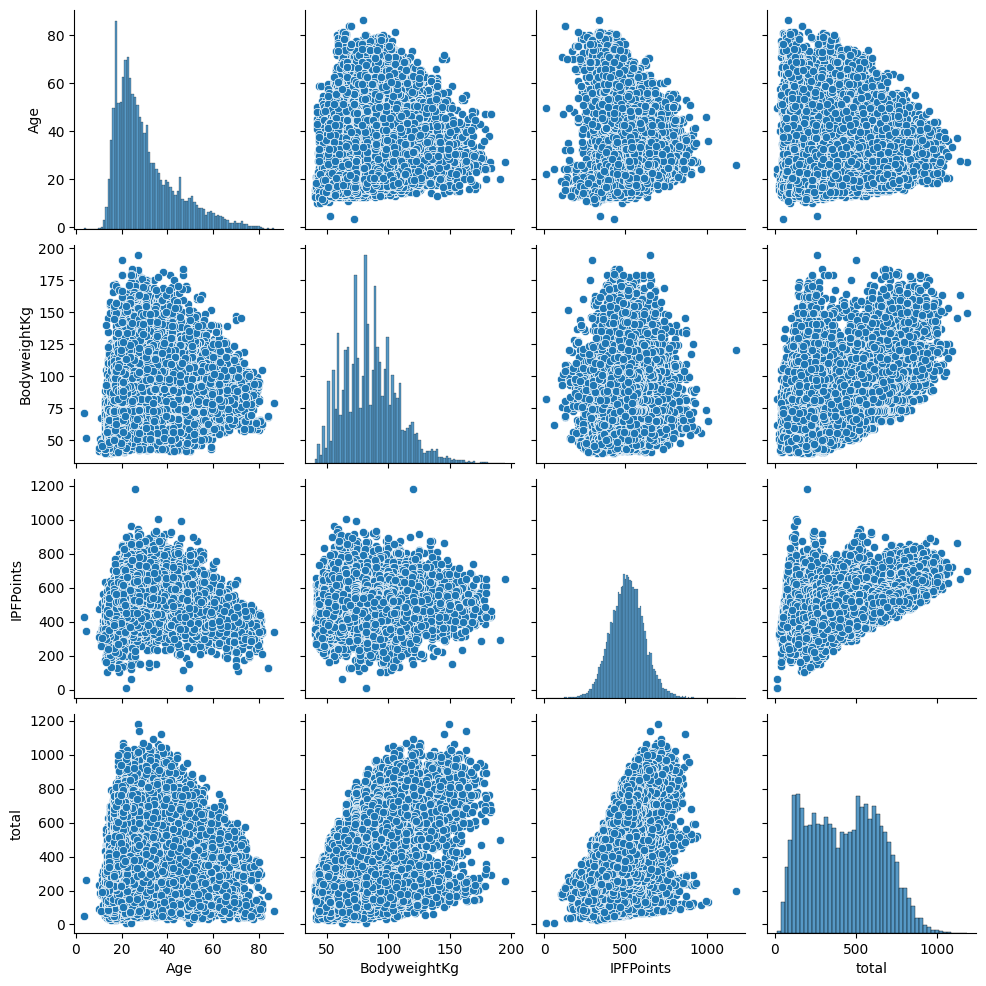


 ===================== Matrice de corrélations ========================== 

                   Age  BodyweightKg  IPFPoints     total
Age           1.000000      0.184306  -0.004832 -0.130932
BodyweightKg  0.184306      1.000000   0.111170  0.404291
IPFPoints    -0.004832      0.111170   1.000000  0.393335
total        -0.130932      0.404291   0.393335  1.000000

 ===================== Description statistique ========================== 

count    26305.000000
mean       428.231750
std        220.495467
min         10.000000
25%        235.000000
50%        430.000000
75%        602.500000
max       1180.000000
Name: TotalKg, dtype: float64
count    26305.000000
mean        30.345923
std         13.127735
min          3.500000
25%         21.000000
50%         26.500000
75%         36.500000
max         86.500000
Name: Age, dtype: float64
count    26305.000000
mean        85.624555
std         22.481679
min         40.000000
25%         69.200000
50%         82.700000
75%         99.4

[None, None, None]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n ===================== Pairplot ========================== \n")
sns.pairplot(X.assign(total = y))
plt.show()

print("\n ===================== Matrice de corrélations ========================== \n")
print(X.assign(total = y).corr())
print("\n ===================== Description statistique ========================== \n")
print(y.describe())
[print(X[col].describe()) for col in X_train.columns]

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor

reg_lin = LinearRegression().fit(X_train, y_train)
y_hat_lin = reg_lin.predict(X_test)
error_lin = np.mean((np.array(y_hat_lin) - np.array(y_test))**2)**.5
print(error_lin)
print(reg_lin.coef_)

poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
reg_poly = LinearRegression().fit(X_train_poly, y_train)
y_hat_poly = reg_poly.predict(X_test_poly)
error_poly = np.mean((np.array(y_hat_poly) - np.array(y_test))**2)**.5
print(error_poly)
print(reg_poly.coef_)

182.04767661027887
[-3.41958747  3.97659393  0.7375705 ]
176.86788202420672
[ 0.00000000e+00  1.39778055e+01  5.91308720e+00  1.58799118e+00
 -5.06012219e-02 -3.69168908e-02 -2.26108480e-02 -2.45690569e-02
  7.14520630e-03 -8.07640756e-04]


Il semble que l'utilisation de modele polynomiale ne soit pas plus beaucoup pertinente que l'utilisation d'un modèle linéaire pour deux raison: les contours des évolutions des nuages de points semblent linéaires d'une variable par rapport à l'autre et la regression linéaire obtient une erreur similaire à celle des regressions polynomiales

## Regression quantile

In [ ]:
alpha = 0.1
# peu de données d'entrées donc on ne regularise pas
qr_down = QuantileRegressor(quantile=alpha/2, alpha = 0, solver='highs').fit(X_train, y_train)
qr_up = QuantileRegressor(quantile=1-alpha/2, alpha = 0, solver='highs').fit(X_train, y_train)

# intervalle de prédiction défini par les regression quantiles
lower = qr_down.predict(X_test)
upper = qr_up.predict(X_test)
prop = np.mean([(y_test > lower) & (y_test < upper)])
print(prop)

0.8912754229233986


In [ ]:
np.mean(upper-lower)

501.5394105511225

## SCP

In [ ]:
## SCP
X_train2, X_calib, y_train2, y_calib = train_test_split(X_train, y_train, test_size=0.6, random_state=13)
modele = LinearRegression().fit(X_train2, y_train2) # Entrainement

# Calibration
y_hat_calib = modele.predict(X_calib)
S = np.abs(y_hat_calib - y_calib) # Scores de conformités
q_S = np.quantile(S, 1-alpha)

# Construction de l'intervalle
y_hat_test = modele.predict(X_test)
lower_scp = y_hat_test - q_S
upper_scp = y_hat_test + q_S
prop_scp = np.mean([(y_test > lower_scp) & (y_test < upper_scp)])
print(prop_scp)

0.8964075270861053


In [ ]:
q_S*2

586.7073609224203

## JackKnife

In [ ]:
## jackknife

# scores de conformité
lower_jn = []
upper_jn = []
for i in X_train.index:
  modele_jack = LinearRegression().fit(X_train.drop(i), y_train.drop(i))
  diff_jn = np.absolute(modele_jack.predict([X_train.loc[i]]) - y_train.loc[i])
  y_hat = modele_jack.predict(X_test)
  upper_jn.append(y_hat + diff_jn)
  lower_jn.append(y_hat - diff_jn)

In [ ]:
# construction des intervales
y_low = []
y_up = []
for i in range(np.array(upper_jn).shape[1]):
  y_up.append(np.quantile(np.array(upper_jn)[:, i], 1- alpha))
  y_low.append(np.quantile(np.array(lower_jn)[:, i], alpha))

In [ ]:
prop_jn = np.mean([(y_test > y_low) & (y_test < y_up)])
print(prop_jn)

0.8988785402014826


In [ ]:
np.mean(np.array(y_up) - np.array(y_low))

588.2559130347834

# Classification

## Chargement et description des données

In [ ]:
from sklearn.ensemble import RandomForestClassifier

mnist_train = pd.read_csv("https://github.com/ugozennaro/conformal_prediction/raw/main/datasets/fashion-mnist_train.csv")
mnist_test = pd.read_csv("https://github.com/ugozennaro/conformal_prediction/raw/main/datasets/fashion-mnist_test.csv")

d = {"0": "T-shirt/top",
"1": "Trouser",
"2": "Pullover",
"3": "Dress",
"4": "Coat",
"5": "Sandal",
"6": "Shirt",
"7": "Sneaker",
"8": "Bag",
"9": "Ankle boot"}

y_test = [d[str(y)] for y in mnist_test['label'].values]
y_train = [d[str(y)] for y in mnist_train['label'].values]

X_test = np.array(mnist_test.drop('label', 1))
X_train = np.array(mnist_train.drop('label', 1))

alpha = 0.1

In [ ]:
# Informations sur les données
print(X_train.shape)
print(X_test.shape)
print(np.min(X_train))
print(np.max(X_train))

(20000, 784)
(10000, 784)
0
255


## Définition des scores

In [ ]:
# fonction score
def score_classif(y_prob, y_gold, classes, algo = 1):
  n = len(y_gold)
  prob_y_gold = np.array([y_prob[i][y_gold[i] == classes] for i in range(n)])
  if algo == 1:
    S = 1 - prob_y_gold
  elif algo == 2:
    S = np.array([np.sum(y_prob[i][y_prob[i] > prob_y_gold[i]]) for i in range(n)])
  return S


## SCP

In [ ]:
# données de calibration
X_train2, X_calib, y_train2, y_calib = train_test_split(X_train, y_train, test_size=0.6, random_state=13)
modele = RandomForestClassifier().fit(X_train2, y_train2)
y_hat_calib = modele.predict_proba(X_calib)
n_calib = len(y_hat_calib)
classes = modele.classes_

In [ ]:
# score sur les données de calibration
S1 = score_classif(y_hat_calib, y_calib, classes, algo = 1)
S2 = score_classif(y_hat_calib, y_calib, classes, algo = 2)

q_S1 = np.quantile(S1, 1-alpha)
q_S2 = np.quantile(S2, 1-alpha)

In [ ]:
def s2(proba, q_S, classes):
  S = []
  for p in proba:
    sum = 0
    yc = []
    usable = np.array([True] * len(classes))
    while sum < q_S:
      max = np.max(p[usable])
      usable[p == max] = False
      yc  = yc + list(classes[p == max])
      sum = sum + max * np.sum(p == max)
    S.append(yc)
  return S

## Résultats et analyse

In [ ]:
y_hat_test = modele.predict_proba(X_test)

s1 = 1 - y_hat_test
y_conformal = [list(classes[s1[i] < q_S1]) for i in range(len(y_hat_test))]
np.mean([y_test[i] in y_conformal[i] for i in range(len(y_test))])

0.8931

In [ ]:
y_conformal2 = s2(y_hat_test, q_S2, classes)
np.mean([y_test[i] in y_conformal2[i] for i in range(len(y_test))])

0.8945

In [ ]:
print(np.unique([len(y_conformal[i]) for i in range(len(y_test))], return_counts = True))
print(np.unique([len(y_conformal2[i]) for i in range(len(y_test))], return_counts = True))

(array([0, 1, 2, 3]), array([ 159, 8604, 1234,    3]))
(array([1, 2, 3, 4]), array([8613, 1315,   66,    6]))


In [ ]:
print(np.mean([len(y_conformal[i]) for i in range(len(y_test))]))
print(np.mean([len(y_conformal2[i]) for i in range(len(y_test))]))

1.1081
1.1465


In [ ]:
i_stric_pos = [len(y_conformal[i])!=0 for i in range(len(y_test))]
y_test0 = np.array(y_test)[i_stric_pos]
y_conformal0 = np.array(y_conformal)[i_stric_pos]
print(np.mean([y_test0[i] in y_conformal0[i] for i in range(len(y_test0))]))

print(np.sum(1 - np.array(i_stric_pos))/ len(i_stric_pos))

0.9087398373983739
0.016
